In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.base import clone
import joblib
import matplotlib.pyplot as plt

In [2]:
# 1. Load dataset
# =======================
data = pd.read_csv(r"D:\onedrive\Desktop\cement_strength_detection\Concrete_Data.csv")
print("Dataset Shape:", data.shape)
print("Columns:", data.columns.tolist())
print("Missing Values:\n", data.isnull().sum())

Dataset Shape: (1030, 9)
Columns: ['Cement (component 1)(kg in a m^3 mixture)', 'Blast Furnace Slag (component 2)(kg in a m^3 mixture)', 'Fly Ash (component 3)(kg in a m^3 mixture)', 'Water  (component 4)(kg in a m^3 mixture)', 'Superplasticizer (component 5)(kg in a m^3 mixture)', 'Coarse Aggregate  (component 6)(kg in a m^3 mixture)', 'Fine Aggregate (component 7)(kg in a m^3 mixture)', 'Age (day)', 'Concrete compressive strength(MPa, megapascals) ']
Missing Values:
 Cement (component 1)(kg in a m^3 mixture)                0
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    0
Fly Ash (component 3)(kg in a m^3 mixture)               0
Water  (component 4)(kg in a m^3 mixture)                0
Superplasticizer (component 5)(kg in a m^3 mixture)      0
Coarse Aggregate  (component 6)(kg in a m^3 mixture)     0
Fine Aggregate (component 7)(kg in a m^3 mixture)        0
Age (day)                                                0
Concrete compressive strength(MPa, megapascals)       

In [3]:
# Fill missing values with mean (zeros are meaningful)
data = data.fillna(data.mean())

In [4]:
# 2. Separate features and target
# =======================
target_col = 'Concrete compressive strength(MPa, megapascals) '
X = data.drop(columns=target_col)
y = data[target_col]

In [5]:
# 3. Scale features
# =======================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# 4. Cluster the data
# =======================
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)
print("\nCluster distribution:", np.bincount(cluster_labels))


Cluster distribution: [184 209  50 248 339]



--- Cluster 0 ---
Linear Regression -> R2: 0.5784, RMSE: 9.6536
Random Forest -> R2: 0.9574, RMSE: 3.0675
Best hyperparameters for Random Forest in cluster 0: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
✅ Selected best model for cluster 0: Random Forest


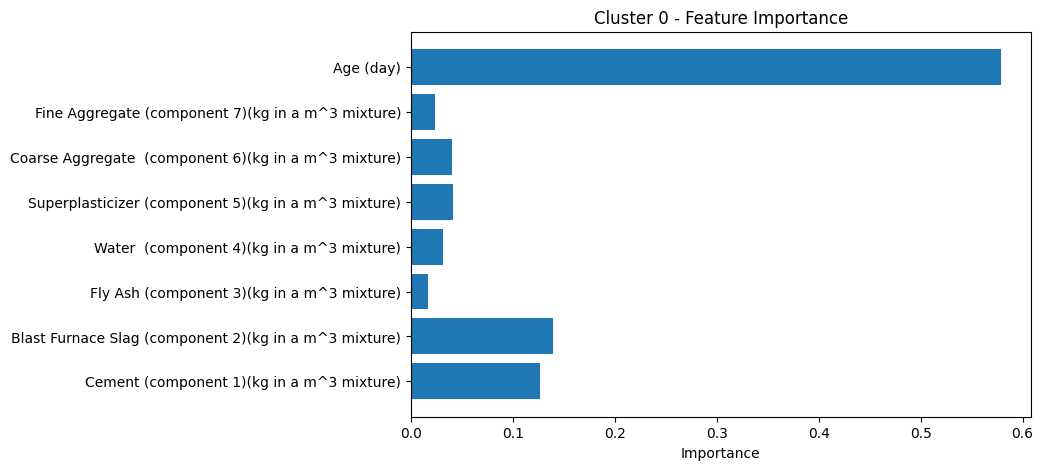


--- Cluster 1 ---
Linear Regression -> R2: 0.7775, RMSE: 7.0710
Random Forest -> R2: 0.9779, RMSE: 2.2277
Best hyperparameters for Random Forest in cluster 1: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 300}
✅ Selected best model for cluster 1: Random Forest


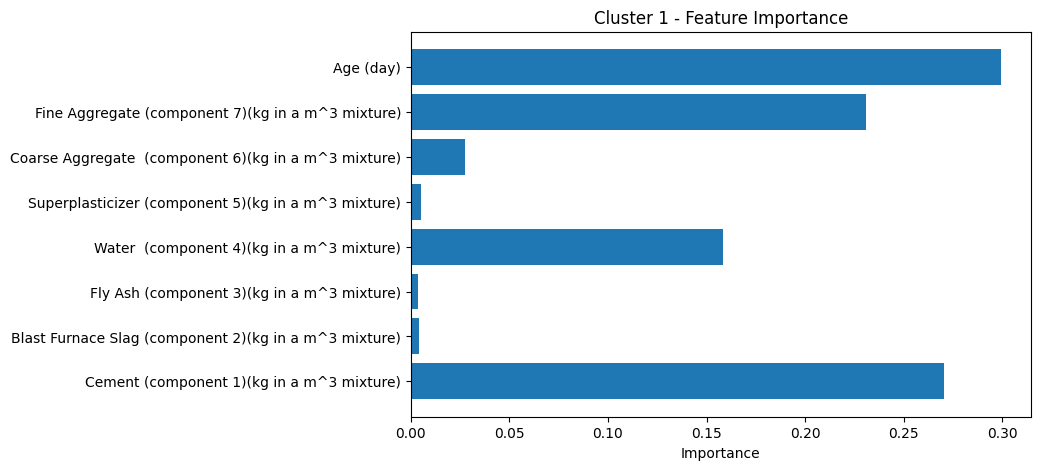


--- Cluster 2 ---
Linear Regression -> R2: 0.6277, RMSE: 5.9438
Random Forest -> R2: 0.9857, RMSE: 1.1643
Best hyperparameters for Random Forest in cluster 2: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
✅ Selected best model for cluster 2: Random Forest


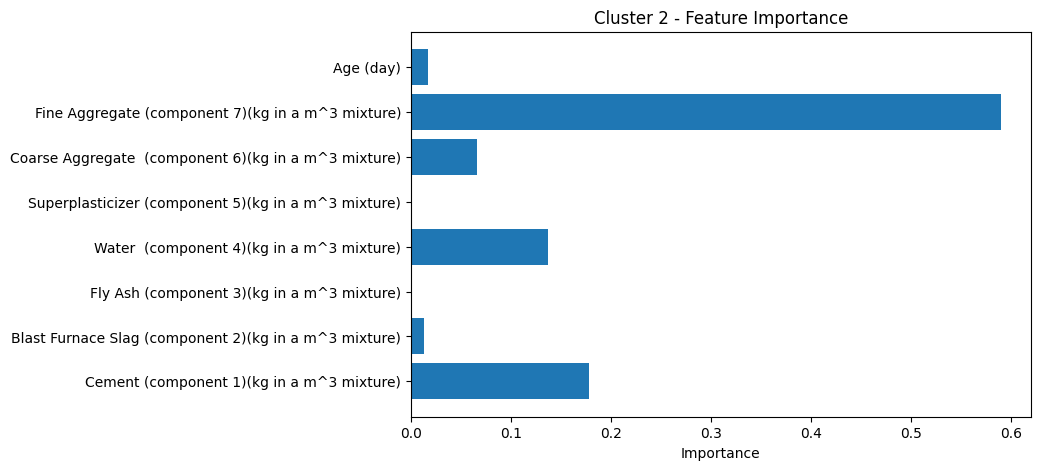


--- Cluster 3 ---
Linear Regression -> R2: 0.7399, RMSE: 7.1395
Random Forest -> R2: 0.9851, RMSE: 1.7110
Best hyperparameters for Random Forest in cluster 3: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
✅ Selected best model for cluster 3: Random Forest


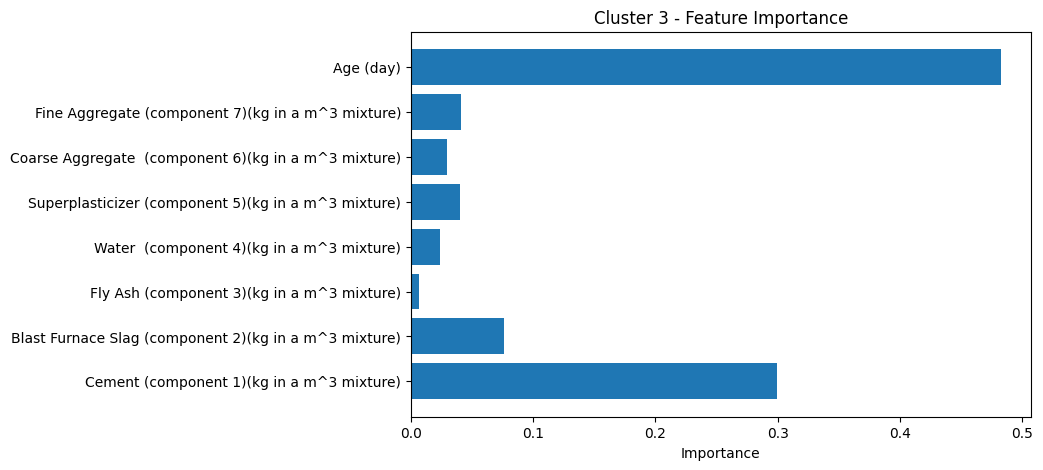


--- Cluster 4 ---
Linear Regression -> R2: 0.7791, RMSE: 6.5838
Random Forest -> R2: 0.9858, RMSE: 1.6698
Best hyperparameters for Random Forest in cluster 4: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
✅ Selected best model for cluster 4: Random Forest


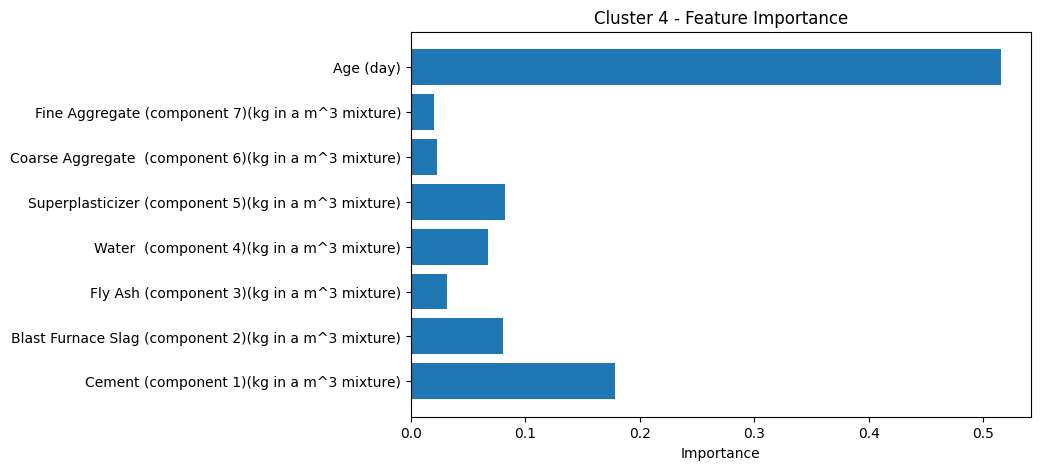

In [7]:
# 5. Train cluster-specific models with GridSearchCV + k-fold CV
# =======================
best_models = {}

for cluster in range(n_clusters):
    print(f"\n--- Cluster {cluster} ---")
    
    X_cluster = X_scaled[cluster_labels == cluster]
    y_cluster = y[cluster_labels == cluster]
    
    # Linear Regression baseline
    lr_model = LinearRegression()
    lr_model.fit(X_cluster, y_cluster)
    y_pred_lr = lr_model.predict(X_cluster)
    lr_r2 = r2_score(y_cluster, y_pred_lr)
    lr_rmse = np.sqrt(mean_squared_error(y_cluster, y_pred_lr))
    
    # Random Forest with GridSearchCV
    rf_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(rf, rf_param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_cluster, y_cluster)
    
    rf_model = grid_search.best_estimator_
    y_pred_rf = rf_model.predict(X_cluster)
    rf_r2 = r2_score(y_cluster, y_pred_rf)
    rf_rmse = np.sqrt(mean_squared_error(y_cluster, y_pred_rf))
    
    # Print metrics
    print(f"Linear Regression -> R2: {lr_r2:.4f}, RMSE: {lr_rmse:.4f}")
    print(f"Random Forest -> R2: {rf_r2:.4f}, RMSE: {rf_rmse:.4f}")
    print(f"Best hyperparameters for Random Forest in cluster {cluster}: {grid_search.best_params_}")
    
    # Select best model per cluster
    if rf_r2 >= lr_r2:
        best_models[cluster] = rf_model
        best_model_name = "Random Forest"
    else:
        best_models[cluster] = lr_model
        best_model_name = "Linear Regression"
    
    print(f"✅ Selected best model for cluster {cluster}: {best_model_name}")
    
    # Feature importance for Random Forest
    if best_model_name == "Random Forest":
        importances = rf_model.feature_importances_
        plt.figure(figsize=(8,5))
        plt.barh(X.columns, importances)
        plt.xlabel("Importance")
        plt.title(f"Cluster {cluster} - Feature Importance")
        plt.show()

In [8]:
# 6. Save scaler, KMeans, and best models
# =======================
joblib.dump(scaler, "scaler.pkl")
joblib.dump(kmeans, "kmeans.pkl")
joblib.dump(best_models, "best_models_per_cluster.pkl")
print("\nScaler, KMeans, and cluster models saved!")


Scaler, KMeans, and cluster models saved!


In [9]:
# 7. Prediction function
# =======================
def predict_new(sample):
    """
    Predict compressive strength for a new concrete mix.
    sample: dict, pandas Series, or 1D numpy array of raw feature values
    """
    # Convert dict to array if needed
    if isinstance(sample, dict):
        sample = np.array([sample[col] for col in X.columns])
    elif isinstance(sample, pd.Series):
        sample = sample[X.columns].values
    
    sample = np.array(sample).reshape(1, -1)
    sample_scaled = scaler.transform(sample)
    cluster = kmeans.predict(sample_scaled)[0]
    model = best_models[cluster]
    prediction = model.predict(sample_scaled)
    return prediction[0]

In [10]:
# 8. Test predictions
# =======================
for i in [0, 4, 10, 20]:
    sample_raw = X.iloc[i].values
    pred = predict_new(sample_raw)
    print(f"Sample {i} prediction: {pred:.2f} MPa")

Sample 0 prediction: 73.24 MPa
Sample 4 prediction: 42.17 MPa
Sample 10 prediction: 39.28 MPa
Sample 20 prediction: 42.12 MPa


c:\Users\chval\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\chval\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\chval\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\chval\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
X.iloc[19].values # == 21 of the excel

array([475.,   0.,   0., 228.,   0., 932., 594., 180.])

In [20]:
# Example: Predict a specific row by index
row_index = 19  # choose any index you like
sample_raw = X.iloc[row_index].values  # get raw feature values
prediction = predict_new(sample_raw)
print(f"Prediction for row {row_index}: {prediction:.2f} MPa")


Prediction for row 19: 42.41 MPa


c:\Users\chval\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [12]:
# Example: Predict for a completely new mix
new_sample = {
    'Cement (kg/m3)': 500,
    'Blast Furnace Slag (kg/m3)': 0,
    'Fly Ash (kg/m3)': 50,
    'Water (kg/m3)': 180,
    'Superplasticizer (kg/m3)': 0,
    'Coarse Aggregate (kg/m3)': 1000,
    'Fine Aggregate (kg/m3)': 800,
    'Age (days)': 28
}

# Convert to numpy array
new_sample_array = np.array(list(new_sample.values()))
prediction = predict_new(new_sample_array)
print(f"Predicted compressive strength: {prediction:.2f} MPa")


Predicted compressive strength: 49.51 MPa


c:\Users\chval\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
